# Visualising Greeks & Sketching the Black-Scholes PDE (Itô Derivation)

This notebook does two things:

1. **Visual diagnostics for Black-Scholes Greeks**  
   We plot Δ, Γ, Θ, Vega and Rho to see how the risk-sensitivities of a European option change with underlying price and volatility.

2. **Quick symbolic sketch of the Black-Scholes partial differential equation**  
   Using *Itô’s Lemma*, we derive the PDE that underpins the pricing formula and show how risk-neutral valuation leads to the familiar closed-form solution.

These visual and mathematical components deepen intuition and bridge the gap between theory and numerical methods used later in the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

### Parameter settings used throughout

| Symbol | Meaning                       | Value |
|--------|------------------------------|-------|
| $(S_0)$ | Spot price                   | 100   |
| $(K)$   | Strike                       | 100   |
| $(T)$   | Time to maturity (years)     | 1.0   |
| $(r)$   | Risk-free rate               | 5 %   |
| $(\sigma)$ | Volatility (annualised)  | 20 %  |

In [2]:
def black_scholes_price(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

### Option value surface

The next cell computes a call-price surface over a range of strikes and volatilities:

* **X-axis:** strike \(K\)  
* **Y-axis:** volatility \(\sigma\)  
* **Z-axis:** Black-Scholes price \(V\)

This visualises the monotonically increasing relationship between price and volatility, and the convexity with respect to strike.

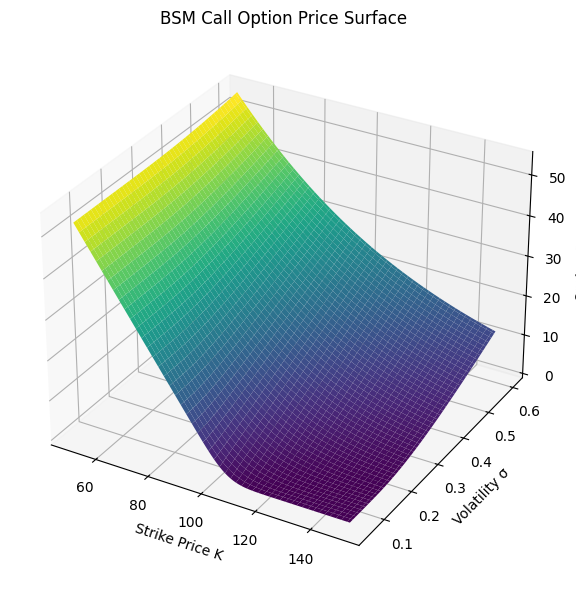

In [3]:
S = 100
T = 1
r = 0.05

strikes = np.linspace(50, 150, 100)
vols = np.linspace(0.05, 0.6, 100)
K_grid, sigma_grid = np.meshgrid(strikes, vols)

price_surface = black_scholes_price(S, K_grid, T, r, sigma_grid, option_type="call")

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(K_grid, sigma_grid, price_surface, cmap="viridis")

ax.set_xlabel("Strike Price K")
ax.set_ylabel("Volatility σ")
ax.set_zlabel("Option Price")
ax.set_title("BSM Call Option Price Surface")
plt.tight_layout()

# save the plot into plots folder
plt.savefig("../../plots/bsm_surface.png", dpi=300)

plt.show()

The surface confirms expected behavior — option price decreases with higher strike \( K \), and increases with higher volatility $( \sigma )$. The curvature also reflects convexity due to the optionality.

### Computing Greeks

`compute_greeks` returns $(\Delta, \Gamma, \Theta, \text{Vega}, \text{Rho})$ for given parameters.  
We will visualise each Greek with respect to underlying price to show hedge-ratio behaviour.

In [4]:
def compute_greeks(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    theta = -S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(
        -r * T
    ) * norm.cdf(d2)
    rho = K * T * np.exp(-r * T) * norm.cdf(d2)

    return delta, gamma, vega, theta, rho

## Delta Sensitivity Plot

This plot shows how the Delta of a call option changes with respect to the underlying stock price \( S \). Delta approaches 1 for deep in-the-money calls and 0 for deep out-of-the-money calls.

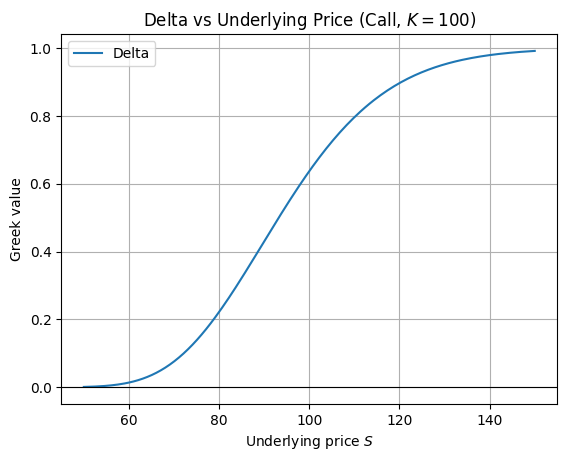

In [5]:
S_vals = np.linspace(50, 150, 200)
greeks = [compute_greeks(S, 100, 1, 0.05, 0.2)[0] for S in S_vals]

plt.plot(S_vals, greeks, label="Delta")
plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("Underlying price $S$")
plt.ylabel(r"Greek value")
plt.title("Delta vs Underlying Price (Call, $K=100$)")
plt.legend()
plt.grid(True)

**Interpretation**

- $(\Delta)$ approaches 0 for deep OTM calls (left) and 1 for deep ITM calls (right).  
- Near-ATM, $(\Delta)$ is about 0.5, giving the familiar *half-delta hedge* intuition.

---

## Sketch derivation of the Black-Scholes PDE with *Itô’s Lemma*

Below we use **SymPy** to symbolically apply Itô’s Lemma to a generic option value \(V(S,t)\) under risk-neutral GBM:

$
dS_t = rS_t\,dt + \sigma S_t\,dW_t
$

The lemma leads to

$
dV = \left(\partial_t V + \frac{1}{2}\sigma^2 S^2 \partial_{SS} V + rS \partial_S V\right) dt + \sigma S \partial_S V\, dW_t .
$

A self-financing delta-hedged portfolio eliminates the \(dW_t\) term, giving the celebrated PDE

$
\partial_t V + \frac12 \sigma^2 S^2 \partial_{SS} V + rS \partial_S V - rV = 0 .
$

Solving this PDE with terminal condition $(V(S,T)=\max(S-K,0))$ yields the Black-Scholes formula implemented earlier.

In [6]:
import sympy as sp

t, S, sigma, r = sp.symbols("t S sigma r")
V = sp.Function("V")(S, t)  # option value function

# Partial derivatives
dVdS = sp.diff(V, S)
dVdSS = sp.diff(dVdS, S)
dVdt = sp.diff(V, t)

# Ito's Lemma on dV
dV = dVdt + r * S * dVdS + 0.5 * sigma**2 * S**2 * dVdSS

# BSM PDE: dVdt + 0.5*sigma^2*S^2*d2VdS2 + r*S*dVdS - r*V = 0
BSM_PDE = dVdt + 0.5 * sigma**2 * S**2 * dVdSS + r * S * dVdS - r * V
sp.pprint(BSM_PDE)

           2                                                      
     2  2 ∂                  ∂                         ∂          
0.5⋅S ⋅σ ⋅───(V(S, t)) + S⋅r⋅──(V(S, t)) - r⋅V(S, t) + ──(V(S, t))
            2                ∂S                        ∂t         
          ∂S                                                      


### Take-aways

* Visuals make the *shape* of each Greek intuitive and highlight where hedging is most sensitive.  
* The Itô-based PDE derivation connects risk-neutral dynamics and the closed-form solution.  
* These insights guide numerical schemes (binomial, finite-difference) and variance-reduced Monte Carlo methods used later in the project.